# Age Estimation using VGG16 and Data Augmentation with an unbalanced Dataset

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.utils import shuffle

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

%matplotlib inline

from PIL import Image
import shutil

## Age estimation in age groups

### Set image size and variables 

In [2]:
IMAGE_SIZE = [224,224]
TRAIN_TEST_SPLIT = 0.3
BASE_DIR = '../input/utkface-new/UTKFace/'
NR_EPOCHS = 30

### Define methods map direct age to classes

In [3]:
def age_to_class( age ):
  age_class = None
  # 0 (0-20)
  if 0 <= age <= 20:
    age_class = 0
  # 1 (20-40)
  if 20 < age <= 40:
    age_class = 1
  # 2 (40-60)
  if 40 < age <= 60:
    age_class = 2
  # 3 (40-60)
  if 60 < age <= 80:
    age_class = 3
  # 3 (80+)
  if age > 80:
    age_class = 4
  return age_class

# map age classes for age gaps
age_dict = {0:'0-20', 1:'20-40',2:'40-60', 3:'60-80', 4:'80+'}

def decode_age_label(age_id):
  return age_dict[int(age_id)]

### Read input dataset

In [4]:
# read labels of image age, gender
image_paths = []
age_labels = []
gender_labels =[]
age_class = []

for filename in tqdm(os.listdir(BASE_DIR)):
  #read image path
  image_path = os.path.join(BASE_DIR, filename)
  #split filename to extract labels
  temp= filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)
  age_class.append(age_to_class(age))

# extract name of file 
names = []
for path in image_paths:
  temp = path.split('/')
  names.append(temp[4])

#convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['age_class'], df['name'] = image_paths, age_labels, gender_labels, age_class, names
df.head()
df

# get and print the number of images in dataframe
age_verbose = [age_dict[int(age)] for age in df['age_class']]

print(Counter(age_verbose))



  0%|          | 0/23708 [00:00<?, ?it/s]

Counter({'20-40': 12123, '0-20': 4877, '40-60': 4311, '60-80': 1857, '80+': 540})


### Shuffle dataset

In [5]:
# shuffle dataset for downsampling
df = shuffle(df)

In [6]:
# check dataframe
df 

,image,age,gender,age_class,name
5337,../input/utkface-new/UTKFace/10_1_3_2017010920...,10,1,0,10_1_3_20170109205323078.jpg.chip.jpg
15695,../input/utkface-new/UTKFace/26_1_3_2017010422...,26,1,1,26_1_3_20170104222855375.jpg.chip.jpg
13842,../input/utkface-new/UTKFace/68_0_3_2017011717...,68,0,3,68_0_3_20170117172636569.jpg.chip.jpg
3891,../input/utkface-new/UTKFace/1_1_2_20161219161...,1,1,0,1_1_2_20161219161757030.jpg.chip.jpg
19403,../input/utkface-new/UTKFace/44_0_0_2017011318...,44,0,2,44_0_0_20170113184633535.jpg.chip.jpg
...,...,...,...,...,...
23410,../input/utkface-new/UTKFace/30_1_3_2017011919...,30,1,1,30_1_3_20170119195850724.jpg.chip.jpg
13403,../input/utkface-new/UTKFace/45_0_1_2017011614...,45,0,2,45_0_1_20170116142935103.jpg.chip.jpg
15566,../input/utkface-new/UTKFace/35_0_1_2017011717...,35,0,1,35_0_1_20170117172007523.jpg.chip.jpg
21938,../input/utkface-new/UTKFace/25_0_1_2017011719...,25,0,1,25_0_1_20170117195010460.jpg.chip.jpg


### Data Augmentation

In [7]:
# create new folder for Data Augmentation
os.mkdir('./ds')

In [8]:
# copy all images of the downsampled df
image_list = df['image']
name_list = df['name']
source = '../input/utkface-new/'
#dest =  '../ds/'
dest = './ds/'

for key, val in df.iterrows():
    shutil.copyfile(val['image'], dest+val['name'])

print("finished copying images")

finished copying images


In [9]:
#zip for better download
#shutil.make_archive('new_ds', 'zip', dest)

In [10]:
# remove folder for new run
#shutil.rmtree('./ds/output/')

In [11]:
# use augmentor to increase the number of images
!pip install Augmentor
import Augmentor as aug

p = aug.Pipeline("./ds")
p.resize(1, 224, 224, resample_filter="ANTIALIAS")
p.flip_left_right(0.5)
p.rotate(0.8, 5, 10)
p.zoom(0.2, 0.9, 1.25)
p.shear(0.1, 0.01, 0.01)
p.sample(55000)

Initialised with 23708 image(s) found.
Output directory set to ./ds/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7FF21877B550>: 100%|██████████| 55000/55000 [08:47<00:00, 104.29 Samples/s]


In [12]:
#zip for better download
shutil.make_archive('new_ds', 'zip', dest)

'/kaggle/working/new_ds.zip'

### Split Dataset into validation and test set  

In [13]:
val_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(val_data.index)

 
print(f"No. of training examples: {val_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

#X = extract_features(training_data['image'])

No. of training examples: 18966
No. of testing examples: 4742


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

val_datagen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)


CLASS_MODE = 'raw'
BATCH_SIZE = 64
BASE_DIR = '../input/utkface-new/UTKFace'

train_generator = train_datagen.flow_from_dataframe(dataframe=df, 
                                                directory=BASE_DIR, 
                                                x_col='name', 
                                                y_col='age_class', 
                                                class_mode=CLASS_MODE,
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True, 
                                                target_size=IMAGE_SIZE)



val_generator = val_datagen.flow_from_dataframe(dataframe=val_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age_class', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)

test_generator = val_datagen.flow_from_dataframe(dataframe=testing_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age_class', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)


Found 23708 validated image filenames.
Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [15]:
from pathlib import Path
path = Path("./models")
path.mkdir(exist_ok=True)


MODEL_PATH = "./models/age_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, 
                                                monitor='val_sparse_categorical_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/age_model_' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)



2022-10-13 22:31:04.794142: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-13 22:31:04.794189: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-13 22:31:04.857753: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-13 22:31:04.893311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-13 22:31:04.893479: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


### Build and load Model

In [16]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [17]:
# load VGG16 without the last 3 Dense layers, in order to train these new
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# check if input type is correct
vgg.inputs

2022-10-13 22:31:24.828531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 22:31:24.923632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 22:31:24.924532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 22:31:24.926011: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]

In [18]:
# all layers before are locked
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# model.summary()
#tf.keras.utils.plot_model( model , to_file='architecture.png' )



# with tpu_strategy.scope():
#     x = Flatten()(vgg.output)
#     x = Dense(4096, activation='relu')(x)
#     x = Dense(4096, activation='relu')(x)
#     prediction = Dense(5, activation='softmax')(x)
#     model = Model(inputs=vgg.input, outputs=prediction)
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [19]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = model.fit(train_generator,
                    epochs=NR_EPOCHS,
                    validation_data=val_generator,
                    callbacks = [tensorboard_callback, checkpoint]
                    )


2022-10-13 22:31:43.044000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-10-13 22:31:45.747129: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/371 [..............................] - ETA: 1:19:13 - loss: 1.7967 - sparse_categorical_accuracy: 0.0781

2022-10-13 22:31:55.946968: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-13 22:31:55.947010: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/371 [..............................] - ETA: 3:00 - loss: 59.2755 - sparse_categorical_accuracy: 0.2578  

2022-10-13 22:31:56.418645: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-13 22:31:56.419211: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-13 22:31:56.561454: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 145 callback api events and 142 activity events. 
2022-10-13 22:31:56.569170: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-13 22:31:56.584182: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/age_model_22-10-13_22-31/train/plugins/profile/2022_10_13_22_31_56

2022-10-13 22:31:56.588336: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/age_model_22-10-13_22-31/train/plugins/profile/2022_10_13_22_31_56/825804f94e2b.trace.json.gz
2022-10-13 22:31:56.609534: I tensorflow/core/profiler/rpc/cli

371/371 [==============================] - 436s 1s/step - loss: 1.2765 - sparse_categorical_accuracy: 0.6516 - val_loss: 0.6856 - val_sparse_categorical_accuracy: 0.7281

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.72815, saving model to ./models/age_best_model.h5
Epoch 2/30
371/371 [==============================] - 431s 1s/step - loss: 0.7414 - sparse_categorical_accuracy: 0.7031 - val_loss: 0.6284 - val_sparse_categorical_accuracy: 0.7516

Epoch 00002: val_sparse_categorical_accuracy improved from 0.72815 to 0.75156, saving model to ./models/age_best_model.h5
Epoch 3/30
371/371 [==============================] - 434s 1s/step - loss: 0.7195 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.6354 - val_sparse_categorical_accuracy: 0.7486

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.75156
Epoch 4/30
371/371 [==============================] - 419s 1s/step - loss: 0.7032 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.6342 - val_spars

### Plot Training and Validation Loss

In [20]:
# print keys 
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

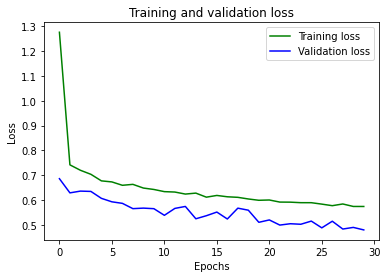

In [21]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

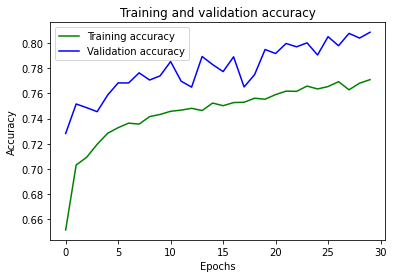

In [22]:
loss_train = history.history['sparse_categorical_accuracy']
loss_val = history.history['val_sparse_categorical_accuracy']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load model and validate

In [23]:
model_age = load_model("./models/age_best_model.h5")
loss, acc = model_age.evaluate(test_generator)
print (loss, acc)

75/75 [==============================] - 19s 245ms/step - loss: 0.4805 - sparse_categorical_accuracy: 0.8049
0.4804902672767639 0.8049346208572388


### Show sample results

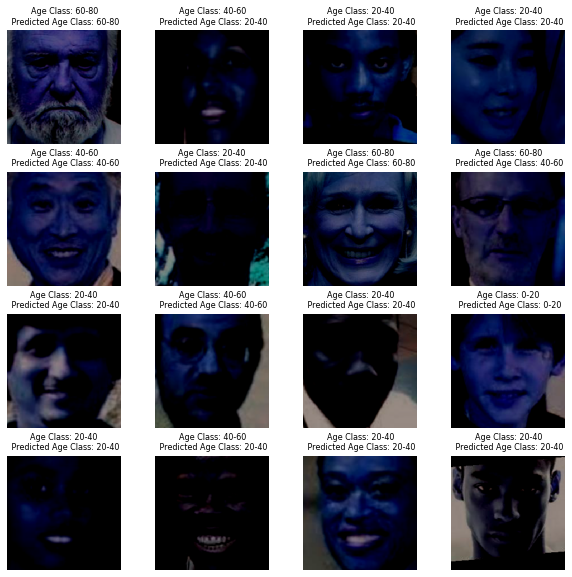

In [24]:
def show_faces(images, age=None, pred_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Age": [pred_age, age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.axis('off')
        #plt.xticks([])
        #plt.yticks([])
        #plt.grid(False)
        plt.imshow(images[i])
        
        if pred_age[i] is None:
            continue
           
            
        real_age = int(age[i])
        predicted_age = np.argmax(predicted[i])
                
                
        plt.title(f"Age Class: {age_dict[real_age]}\n Predicted Age Class: {age_dict[predicted_age]}", fontsize=8)
            
        plt.subplots_adjust(wspace=0.3)

sample_validation_images, sample_validation_labels = next(test_generator)
predicted = model_age.predict(sample_validation_images)
show_faces(sample_validation_images, age=sample_validation_labels, pred_age=predicted)

## Direct Age Estimation

In [25]:
NR_EPOCHS = 30

In [26]:
# reads image_path and returns decoded img 
def process_path(file_path, label):
    #read file path
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #convert the values from 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    # preprocess image for VGG16
    img = preprocess_input(img)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

In [27]:
BASE = "./ds/output/"

In [28]:
# read labels of image age, gender
image_paths = []
age_labels = []
gender_labels =[]
age_class = []
print(len(os.listdir(BASE)))
for filename in tqdm(os.listdir(BASE)):
  image_path = os.path.join(BASE, filename)
  #split filename to get labels
  temp= filename.split('_')
  #print(temp)
  age = int(temp[2])
  gender = int(temp[3])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)
  age_class.append(age_to_class(age))

names = []
for path in image_paths:
  temp = path.split('/')
  #print(temp[3])
  names.append(temp[3])

#convert to dataframe
aug_df = pd.DataFrame()
aug_df['image'], aug_df['age'], aug_df['gender'], aug_df['age_class'], aug_df['name'] = image_paths, age_labels, gender_labels, age_class, names
aug_df.head()
aug_df

age_verbose = [age_dict[int(age)] for age in aug_df['age_class']]

print(Counter(age_verbose))



55000


  0%|          | 0/55000 [00:00<?, ?it/s]

Counter({'20-40': 28155, '0-20': 11370, '40-60': 9990, '60-80': 4280, '80+': 1205})


### Split Dataset in Train, Validation and Test Dataset

In [29]:
training_data = aug_df
val_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(val_data.index)

In [30]:
labels_train =  tf.keras.utils.to_categorical(training_data['age'], num_classes=117)
labels_val =  tf.keras.utils.to_categorical(val_data['age'], num_classes=117)
labels_test =  tf.keras.utils.to_categorical(testing_data['age'], num_classes=117) 

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_data['image'],labels_train))
train_dataset = train_dataset.shuffle(len(training_data))
train_dataset =train_dataset.map(process_path, num_parallel_calls=4)
train_dataset = train_dataset.batch(64)


val_dataset = tf.data.Dataset.from_tensor_slices((val_data['image'],labels_val))
val_dataset = val_dataset.shuffle(len(val_data))
val_dataset = val_dataset.map(process_path, num_parallel_calls=4)
val_dataset = val_dataset.batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((testing_data['image'],labels_test))
test_dataset = test_dataset.shuffle(len(testing_data))
test_dataset = test_dataset.map(process_path, num_parallel_calls=4)
test_dataset = test_dataset.batch(64)

### Load and build model

In [32]:
model2 = VGG16(input_shape=[224,224,3],weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable=False

In [33]:
x2 = Flatten()(model2.output)
x2 = Dense(4096, activation='relu')(x2)
x2 = Dense(4096, activation='relu')(x2)
prediction2 = Dense(117, activation='softmax')(x2)
model_direct = Model(inputs=model2.input, outputs=prediction2)
model_direct.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [34]:
model_direct.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:

DIRECT_PATH = "./models/direct_age_aug_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(DIRECT_PATH, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

import datetime
log_dir = '../tblogs/direct_age_model_aug' + datetime.datetime.now().strftime('%y-%m-%d_%H-%M')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

log_dir

2022-10-14 02:12:26.231751: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-14 02:12:26.231803: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-14 02:12:26.474654: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-14 02:12:26.474843: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


'../tblogs/direct_age_model_aug22-10-14_02-12'

In [36]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history_direct = model_direct.fit(train_dataset,
                    epochs=NR_EPOCHS,
                    batch_size = 64,
                    validation_data=val_dataset,
                    callbacks = [tensorboard_callback, checkpoint]
                    )


Epoch 1/30
  1/860 [..............................] - ETA: 59:00 - loss: 5.9837 - accuracy: 0.0000e+00

2022-10-14 02:12:38.610598: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-14 02:12:38.610647: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/860 [..............................] - ETA: 9:18 - loss: 13.3306 - accuracy: 0.0391    

2022-10-14 02:12:39.315541: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-14 02:12:39.316433: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-14 02:12:39.449107: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 352 callback api events and 349 activity events. 
2022-10-14 02:12:39.459175: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-14 02:12:39.472702: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tblogs/direct_age_model_aug22-10-14_02-12/train/plugins/profile/2022_10_14_02_12_39

2022-10-14 02:12:39.482684: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tblogs/direct_age_model_aug22-10-14_02-12/train/plugins/profile/2022_10_14_02_12_39/825804f94e2b.trace.json.gz
2022-10-14 02:12:39.498396: I tensorflow/c

860/860 [==============================] - 428s 493ms/step - loss: 4.2223 - accuracy: 0.0901 - val_loss: 4.0813 - val_accuracy: 0.0923

Epoch 00001: val_accuracy improved from -inf to 0.09232, saving model to ./models/direct_age_aug_best_model.h5
Epoch 2/30
860/860 [==============================] - 382s 444ms/step - loss: 4.0768 - accuracy: 0.0916 - val_loss: 4.0740 - val_accuracy: 0.0923

Epoch 00002: val_accuracy did not improve from 0.09232
Epoch 3/30
860/860 [==============================] - 421s 489ms/step - loss: 4.0739 - accuracy: 0.0916 - val_loss: 4.0754 - val_accuracy: 0.0923

Epoch 00003: val_accuracy did not improve from 0.09232
Epoch 4/30
860/860 [==============================] - 420s 489ms/step - loss: 4.0732 - accuracy: 0.0916 - val_loss: 4.0727 - val_accuracy: 0.0923

Epoch 00004: val_accuracy did not improve from 0.09232
Epoch 5/30
860/860 [==============================] - 380s 441ms/step - loss: 4.0722 - accuracy: 0.0916 - val_loss: 4.0725 - val_accuracy: 0.0923



### Plot Training and Validation Loss

In [37]:
history_direct.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

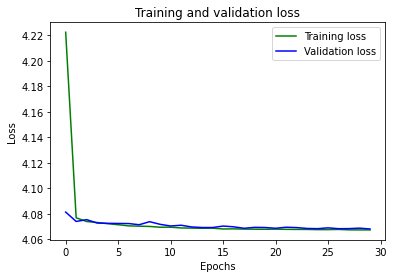

In [38]:
loss_train_direct = history_direct.history['loss']
loss_val_direct = history_direct.history['val_loss']
epochs = range(NR_EPOCHS)
plt.plot(epochs, loss_train_direct, 'g', label='Training loss')
plt.plot(epochs, loss_val_direct, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

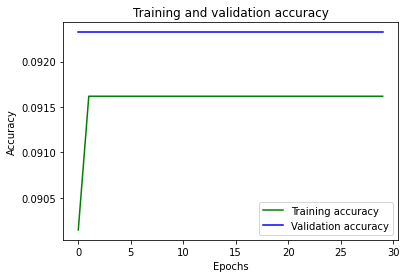

In [39]:
accuracy_direct = history_direct.history['accuracy']
accuracy_val_direct = history_direct.history['val_accuracy']
epochs = range(NR_EPOCHS)
plt.plot(epochs, accuracy_direct, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val_direct, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
from tensorflow.keras.models import load_model

model_age_direct = load_model("./models/direct_age_aug_best_model.h5")
loss, acc = model_age_direct.evaluate(test_dataset)
print(loss, acc)

75/75 [==============================] - 13s 163ms/step - loss: 4.0729 - accuracy: 0.0941
4.072911262512207 0.09405314177274704
